In [1]:
import torch
print("GPU Available:", torch.cuda.is_available())
print("GPU Name:", torch.cuda.get_device_name(0))

GPU Available: True
GPU Name: Tesla T4


In [2]:
!pip install timm
!pip install torchmetrics
!pip install opencv-python
!pip install matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 22.5 MB/s eta 0:00:00


In [3]:
!pip install kaggle

In [6]:
import os

os.makedirs('/root/.kaggle', exist_ok=True)
!cp kaggle.json /root/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

In [7]:
!kaggle datasets download -d masoudnickparvar/brain-tumor-mri-dataset

Dataset URL: https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset
License(s): Attribution 4.0 International (CC BY 4.0)
 94% 148M/157M [00:00<00:00, 1.55GB/s]
100% 157M/157M [00:00<00:00, 1.52GB/s]


In [8]:
!unzip brain-tumor-mri-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: Training/glioma/Tr-gl_279.jpg  
  inflating: Training/glioma/Tr-gl_28.jpg  
  inflating: Training/glioma/Tr-gl_280.jpg  
  inflating: Training/glioma/Tr-gl_281.jpg  
  inflating: Training/glioma/Tr-gl_282.jpg  
  inflating: Training/glioma/Tr-gl_283.jpg  
  inflating: Training/glioma/Tr-gl_284.jpg  
  inflating: Training/glioma/Tr-gl_285.jpg  
  inflating: Training/glioma/Tr-gl_286.jpg  
  inflating: Training/glioma/Tr-gl_287.jpg  
  inflating: Training/glioma/Tr-gl_288.jpg  
  inflating: Training/glioma/Tr-gl_289.jpg  
  inflating: Training/glioma/Tr-gl_29.jpg  
  inflating: Training/glioma/Tr-gl_290.jpg  
  inflating: Training/glioma/Tr-gl_291.jpg  
  inflating: Training/glioma/Tr-gl_292.jpg  
  inflating: Training/glioma/Tr-gl_293.jpg  
  inflating: Training/glioma/Tr-gl_294.jpg  
  inflating: Training/glioma/Tr-gl_295.jpg  
  inflating: Training/glioma/Tr-gl_296.jpg  
  inflating: Training/glioma/Tr-gl_297.jpg  
  infl

In [9]:
!mkdir dataset
!mv Training dataset/train
!mv Testing dataset/val

In [10]:
import os
print(os.listdir("dataset/train"))

['pituitary', 'notumor', 'meningioma', 'glioma']


In [11]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import timm
import matplotlib.pyplot as plt
import numpy as np

In [12]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

train_dataset = datasets.ImageFolder("dataset/train", transform=transform)
val_dataset = datasets.ImageFolder("dataset/val", transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

print("Training samples:", len(train_dataset))
print("Validation samples:", len(val_dataset))

Training samples: 5600
Validation samples: 1600


In [13]:
model = timm.create_model("efficientnet_b0", pretrained=True, num_classes=4)
model = model.cuda()

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

In [14]:
for epoch in range(5):
    model.train()
    running_loss = 0

    for images, labels in train_loader:
        images, labels = images.cuda(), labels.cuda()

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader)}")

Epoch 1, Loss: 0.5363685558363795
Epoch 2, Loss: 0.0588567826351417
Epoch 3, Loss: 0.021523357598343864
Epoch 4, Loss: 0.015510166309624245
Epoch 5, Loss: 0.006564177024390249


In [15]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.cuda(), labels.cuda()
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print("Validation Accuracy:", accuracy)

Validation Accuracy: 93.3125


In [16]:
class_names = train_dataset.classes
print(class_names)

['glioma', 'meningioma', 'notumor', 'pituitary']


In [17]:
def predict_with_confidence(image):
    model.eval()

    image = image.unsqueeze(0).cuda()

    with torch.no_grad():
        outputs = model(image)
        probs = torch.softmax(outputs, dim=1)
        confidence, prediction = torch.max(probs, dim=1)

    predicted_class = class_names[prediction.item()]
    confidence_score = confidence.item()

    if confidence_score < 0.7:
        flag = "Low Confidence - Needs Expert Review"
    else:
        flag = "High Confidence"

    return predicted_class, confidence_score, flag

In [18]:
image, label = val_dataset[0]

pred_class, conf, flag = predict_with_confidence(image)

print("Predicted:", pred_class)
print("Confidence:", conf)
print("Status:", flag)

Predicted: notumor
Confidence: 0.6085464358329773
Status: Low Confidence - Needs Expert Review


In [19]:
all_preds = []
all_labels = []
all_confidences = []

model.eval()

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.cuda(), labels.cuda()
        outputs = model(images)
        probs = torch.softmax(outputs, dim=1)
        confidence, predicted = torch.max(probs, 1)

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_confidences.extend(confidence.cpu().numpy())

In [21]:
import numpy as np

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)
all_confidences = np.array(all_confidences)

In [22]:
threshold = 0.7

high_conf_mask = all_confidences >= threshold

high_conf_accuracy = np.mean(
    all_preds[high_conf_mask] == all_labels[high_conf_mask]
) * 100

print("Accuracy on High Confidence Predictions:", high_conf_accuracy)
print("Coverage (percent of predictions above threshold):",
      np.mean(high_conf_mask) * 100)

Accuracy on High Confidence Predictions: 94.52229299363057
Coverage (percent of predictions above threshold): 98.125


In [23]:
correct_mask = all_preds == all_labels

avg_conf_correct = np.mean(all_confidences[correct_mask])
avg_conf_wrong = np.mean(all_confidences[~correct_mask])

print("Average Confidence (Correct Predictions):", avg_conf_correct)
print("Average Confidence (Wrong Predictions):", avg_conf_wrong)

Average Confidence (Correct Predictions): 0.9930077
Average Confidence (Wrong Predictions): 0.85204905


In [24]:
!pip install scikit-learn

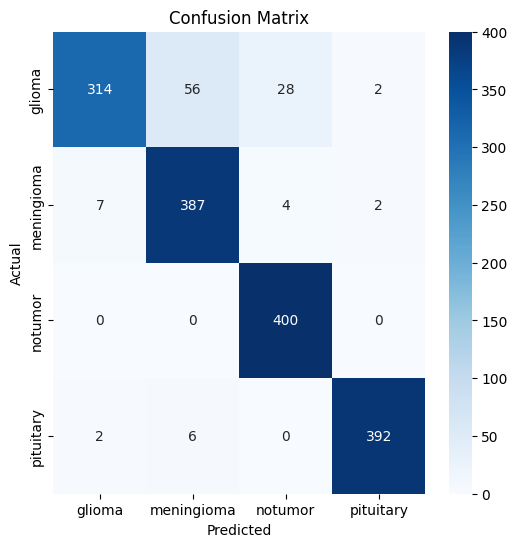

In [25]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=class_names,
            yticklabels=class_names,
            cmap="Blues")

plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [26]:
print(model)

EfficientNet(
  (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNormAct2d(
    32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
    (drop): Identity()
    (act): SiLU(inplace=True)
  )
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn1): BatchNormAct2d(
          32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): SiLU(inplace=True)
        )
        (aa): Identity()
        (se): SqueezeExcite(
          (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
          (act1): SiLU(inplace=True)
          (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
          (gate): Sigmoid()
        )
        (conv_pw): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2

In [27]:
!pip install grad-cam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 82.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad-cam: filename=grad_cam-1.5.5-py3-none-any.whl size=44285 sha256=bbd68fff93418a4dff38336bf31d8b34c242f99b7b2be082a15ad9cd0762d988
  Stored in directory: /root/.cache/pip/wheels/fb/3b/09/2afc520f3d69bc26ae6bd87416759c820a3f7d05c1a077bbf6
Successfully built grad-cam


In [28]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
import numpy as np
import cv2

In [29]:
target_layers = [model.conv_head]

In [31]:
image, label = val_dataset[0]

input_tensor = image.unsqueeze(0).cuda()

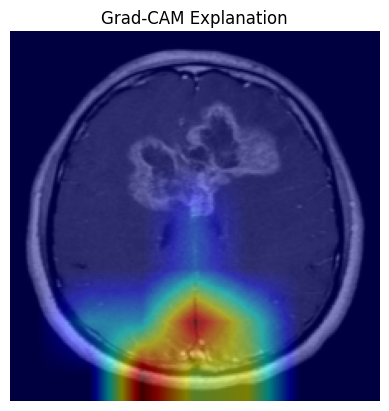

In [32]:
cam = GradCAM(model=model, target_layers=target_layers)

grayscale_cam = cam(input_tensor=input_tensor)[0]

# Convert tensor to numpy image
rgb_img = image.permute(1, 2, 0).numpy()
rgb_img = (rgb_img - rgb_img.min()) / (rgb_img.max() - rgb_img.min())

visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

plt.imshow(visualization)
plt.axis("off")
plt.title("Grad-CAM Explanation")
plt.show()

In [33]:
import torchvision.models as models

resnet = models.resnet18(pretrained=True)
resnet.fc = nn.Linear(resnet.fc.in_features, 4)
resnet = resnet.cuda()

criterion = nn.CrossEntropyLoss()
optimizer_resnet = torch.optim.Adam(resnet.parameters(), lr=1e-4)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 53.7MB/s]


In [34]:
for epoch in range(5):
    resnet.train()
    running_loss = 0

    for images, labels in train_loader:
        images, labels = images.cuda(), labels.cuda()

        optimizer_resnet.zero_grad()
        outputs = resnet(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer_resnet.step()

        running_loss += loss.item()

    print(f"ResNet Epoch {epoch+1}, Loss: {running_loss/len(train_loader)}")

ResNet Epoch 1, Loss: 0.2367591165538345
ResNet Epoch 2, Loss: 0.04760007498253669
ResNet Epoch 3, Loss: 0.021716919095654572
ResNet Epoch 4, Loss: 0.015935028041380323
ResNet Epoch 5, Loss: 0.010326741411783068


In [35]:
resnet.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.cuda(), labels.cuda()
        outputs = resnet(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

resnet_accuracy = 100 * correct / total
print("ResNet Validation Accuracy:", resnet_accuracy)

ResNet Validation Accuracy: 94.4375


In [36]:
correct = 0
total = 0

model.eval()
resnet.eval()

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.cuda(), labels.cuda()

        outputs1 = model(images)
        outputs2 = resnet(images)

        probs1 = torch.softmax(outputs1, dim=1)
        probs2 = torch.softmax(outputs2, dim=1)

        ensemble_probs = (probs1 + probs2) / 2

        _, predicted = torch.max(ensemble_probs, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

ensemble_accuracy = 100 * correct / total
print("Ensemble Validation Accuracy:", ensemble_accuracy)

Ensemble Validation Accuracy: 94.6875


In [37]:
import torch.nn.functional as F

# Redefine classifier with dropout
resnet.fc = nn.Sequential(
    nn.Dropout(p=0.5),
    nn.Linear(resnet.fc[0].in_features if isinstance(resnet.fc, nn.Sequential) else resnet.fc.in_features, 4)
)

resnet = resnet.cuda()

In [38]:
optimizer_resnet = torch.optim.Adam(resnet.parameters(), lr=1e-4)

for epoch in range(3):
    resnet.train()
    running_loss = 0

    for images, labels in train_loader:
        images, labels = images.cuda(), labels.cuda()

        optimizer_resnet.zero_grad()
        outputs = resnet(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer_resnet.step()

        running_loss += loss.item()

    print(f"Dropout ResNet Epoch {epoch+1}, Loss: {running_loss/len(train_loader)}")

Dropout ResNet Epoch 1, Loss: 0.07168579157441854


KeyboardInterrupt: 

In [39]:
def mc_dropout_predict(model, image, mc_runs=20):
    model.train()  # activate dropout

    image = image.unsqueeze(0).cuda()

    probs_list = []

    with torch.no_grad():
        for _ in range(mc_runs):
            outputs = model(image)
            probs = torch.softmax(outputs, dim=1)
            probs_list.append(probs.cpu().numpy())

    probs_array = np.array(probs_list)

    mean_probs = probs_array.mean(axis=0)
    variance = probs_array.var(axis=0)

    predicted_class = class_names[np.argmax(mean_probs)]
    uncertainty_score = variance.mean()

    return predicted_class, uncertainty_score

In [40]:
image, label = val_dataset[0]

pred_class, uncertainty = mc_dropout_predict(resnet, image)

print("Predicted:", pred_class)
print("Uncertainty Score:", uncertainty)

Predicted: meningioma
Uncertainty Score: 0.008982902


In [41]:
uncertainties_correct = []
uncertainties_wrong = []

resnet.train()  # activate dropout

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.cuda(), labels.cuda()

        for i in range(images.size(0)):
            img = images[i]
            true_label = labels[i].item()

            pred_class, uncertainty = mc_dropout_predict(resnet, img, mc_runs=15)
            pred_index = class_names.index(pred_class)

            if pred_index == true_label:
                uncertainties_correct.append(uncertainty)
            else:
                uncertainties_wrong.append(uncertainty)

print("Avg Uncertainty (Correct):", np.mean(uncertainties_correct))
print("Avg Uncertainty (Wrong):", np.mean(uncertainties_wrong))

Avg Uncertainty (Correct): 0.011101821
Avg Uncertainty (Wrong): 0.011300732


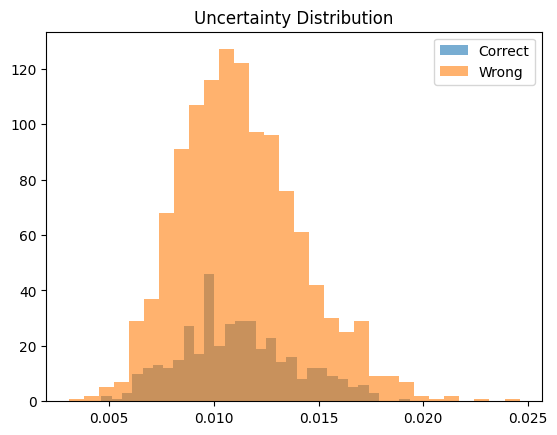

In [42]:
import matplotlib.pyplot as plt

plt.hist(uncertainties_correct, bins=30, alpha=0.6, label='Correct')
plt.hist(uncertainties_wrong, bins=30, alpha=0.6, label='Wrong')
plt.legend()
plt.title("Uncertainty Distribution")
plt.show()

In [43]:
mean_probs = probs_array.mean(axis=0)
variance = probs_array.var(axis=0)

predicted_class = class_names[np.argmax(mean_probs)]

max_class_index = np.argmax(mean_probs)
uncertainty_score = variance[0][max_class_index]

return predicted_class, uncertainty_score

NameError: name 'probs_array' is not defined

In [44]:
def mc_dropout_predict(model, image, mc_runs=40):
    model.train()  # activate dropout

    image = image.unsqueeze(0).cuda()

    probs_list = []

    with torch.no_grad():
        for _ in range(mc_runs):
            outputs = model(image)
            probs = torch.softmax(outputs, dim=1)
            probs_list.append(probs.cpu().numpy())

    probs_array = np.array(probs_list)

    mean_probs = probs_array.mean(axis=0)
    variance = probs_array.var(axis=0)

    predicted_index = np.argmax(mean_probs)
    predicted_class = class_names[predicted_index]

    # Uncertainty only for predicted class
    uncertainty_score = variance[0][predicted_index]

    return predicted_class, uncertainty_score

In [45]:
image, label = val_dataset[0]

pred_class, uncertainty = mc_dropout_predict(resnet, image)

print("Predicted:", pred_class)
print("Uncertainty Score:", uncertainty)

Predicted: meningioma
Uncertainty Score: 0.024991656


In [46]:
uncertainties_correct = []
uncertainties_wrong = []

resnet.train()

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.cuda(), labels.cuda()

        for i in range(images.size(0)):
            img = images[i]
            true_label = labels[i].item()

            pred_class, uncertainty = mc_dropout_predict(resnet, img, mc_runs=40)
            pred_index = class_names.index(pred_class)

            if pred_index == true_label:
                uncertainties_correct.append(uncertainty)
            else:
                uncertainties_wrong.append(uncertainty)

print("Avg Uncertainty (Correct):", np.mean(uncertainties_correct))
print("Avg Uncertainty (Wrong):", np.mean(uncertainties_wrong))

Avg Uncertainty (Correct): 0.019074
Avg Uncertainty (Wrong): 0.019753413


In [47]:
torch.save(model.state_dict(), "efficientnet_model.pth")
torch.save(resnet.state_dict(), "resnet_model.pth")

In [48]:
!git config --global user.email "harinigovindarajan05@gmail.com"
!git config --global user.name "Harinee12"

In [49]:
!git init

hint: Using 'master' as the name for the initial branch. This default branch name
hint: is subject to change. To configure the initial branch name to use in all
hint: of your new repositories, which will suppress this warning, call:
hint: 
hint: 	git config --global init.defaultBranch <name>
hint: 
hint: Names commonly chosen instead of 'master' are 'main', 'trunk' and
hint: 'development'. The just-created branch can be renamed via this command:
hint: 
hint: 	git branch -m <name>
Initialized empty Git repository in /content/.git/


In [50]:
!git add *.ipynb
!git add README.md
!git add requirements.txt

fatal: pathspec '*.ipynb' did not match any files
fatal: pathspec 'README.md' did not match any files
fatal: pathspec 'requirements.txt' did not match any files


In [51]:
!git commit -m "Initial commit - Reliability-aware brain tumor framework"

On branch master

Initial commit

Untracked files:
  (use "git add <file>..." to include in what will be committed)
	.config/
	brain-tumor-mri-dataset.zip
	dataset/
	efficientnet_model.pth
	kaggle.json
	resnet_model.pth
	sample_data/

nothing added to commit but untracked files present (use "git add" to track)


In [52]:
%%writefile .gitignore
dataset/
*.zip
*.pth
kaggle.json
sample_data/
.config/

Writing .gitignore


In [53]:
!git add *.ipynb
!git add .gitignore
!git add README.md
!git add requirements.txt

fatal: pathspec '*.ipynb' did not match any files
fatal: pathspec 'README.md' did not match any files
fatal: pathspec 'requirements.txt' did not match any files


In [54]:
!ls

brain-tumor-mri-dataset.zip  efficientnet_model.pth  resnet_model.pth
dataset			     kaggle.json	     sample_data


In [55]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [56]:
!ls "/content/drive/MyDrive"

 1000060409.pdf
 1000193573_compressed.pdf
'5 (1).rar'
'5 (2).rar'
 5.rar
 89d88c5528513adc4002a1618ce2efb0_iris.csv
 Academic_Rank_List.pdf
'AI-Powered-Smart-Content-Curator (1) (1).pdf'
'AI-Powered-Smart-Content-Curator (1).pdf'
'ChatGPT Image Feb 11, 2026, 10_41_45 AM.png'
'ChatGPT Image Feb 11, 2026, 10_42_48 AM.png'
 Classroom
 cognify_intern-main.zip
'Colab Notebooks'
'Copy of HACK-AI-THON 2.0.pptx'
'Design Thinking - A Primer (1).pdf'
'Document from Harini.pdf'
 faithbound-impactx3.0.pdf_compressed.pdf
 g10.png
'g11 (1).png'
 g11.png
 g12.png
 g20.png
 g3.png
 g44.png
 g8.png
'Gemini_Generated_Image_d9qtyad9qtyad9qt (1).png'
 Gemini_Generated_Image_ff3eq5ff3eq5ff3e.png
 Gemini_Generated_Image_fm5dodfm5dodfm5d.png
'GFG 7.png'
'G.Harini _11A_ArticleWritting.pdf'
'harini 3rd sem.pdf'
'harini_certificates_compressed (1) (1).pdf'
'harini_certificates_compressed (1).pdf'
'Harini_fullstack_certificate(1).pdf'
 HARINIG-IT.pdf
 HARINI_G_page1_removed.pdf
 hariniG.pdf
'HariniGResume (1).p

In [57]:
!ls "/content/drive/MyDrive/Colab Notebooks"

 Brain_Tumor_Confidence_Framework.ipynb  'Untitled (1)'     Untitled4.ipynb
 Brain_Tumor_Research_Project.ipynb	  Untitled1.ipynb   Untitled5.ipynb
 Untitled				  Untitled2.ipynb
 Untitled0.ipynb			  Untitled3.ipynb
